# Libraries

In [1]:
print("Imports - Started")

# Import libraries
import pandas as pd
import numpy as np
import re
import string
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn.metrics import confusion_matrix
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd
from gensim.models import KeyedVectors
import random
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import optuna
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("Imports - Finished")

Imports - Started
Imports - Finished


# Utils

## Random Seed

In [2]:
print("Random seed configuration - Started")

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
    
print("Random seed configuration - Finished")

Random seed configuration - Started
Random seed configuration - Finished


## Preprocessing function

In [3]:
# Preprocessing function
rmv_high_freq_words = False
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    
    # Correct the spelling mistakes
    text = re.sub(r" \b(luv) \b", "love", text)
    text = re.sub(r"\b(amzing) \b", "amazing", text)
    text = re.sub(r"\b(terible) \b", "terrible", text)
    text = re.sub(r"\b(excelent) \b", "excellent", text)
    text = re.sub(r"\b(performnce) \b", "performance", text)
    text = re.sub(r"\b(gud)\b", "good", text)
    text = re.sub(r"\b(vry)\b", "very", text)
    text = re.sub(r"\b(fantstic)\b", "fantastic", text)
    text = re.sub(r"\b(gr8)\b", "great", text)
    text = re.sub(r"\b(i'm)\b", "i am", text)
    text = re.sub(r"\b(horrble)\b", "horrible", text)
    text = re.sub(r"\b(don't)\b", "do not", text)
    text = re.sub(r"\b(did't)\b", "did not", text)
    text = re.sub(r"\b(dont)\b", "do not", text)
    text = re.sub(r"\b(didnt)\b", "did not", text)
    text = re.sub(r"\b(gotta)\b", "got to", text)
    text = re.sub(r"\b(waitin)\b", "waiting", text)
    text = re.sub(r"\b(thru)\b", "through", text)
    text = re.sub(r"\b('re)\b", "are", text)
    text = re.sub(r"\b(sis)\b", "sister", text)
    text = re.sub(r"\b(u)\b", "you", text)
    text = re.sub(r"\b(yeah)\b", "yes", text)
    text = re.sub(r"\b(yeh)\b", "yes", text)
    text = re.sub(r"\b(outta)\b", "out of", text)
    text = re.sub(r"\b(yah)\b", "you", text)
    text = re.sub(r"\b(foun)\b", "found", text)
    text = re.sub(r"\b(yah)\b", "you", text)
    text = re.sub(r"\b(ur)\b", "you are", text)
    text = re.sub(r"\b(sumtimes)\b", "sometimes", text)
    text = re.sub(r"\b(can't)\b", "can not", text)
    text = re.sub(r"\b(cannot)\b", "can not", text)
    text = re.sub(r"\b(commin)\b", "comming", text)
    text = re.sub(r"\b(gonna)\b", "going to", text)
    text = re.sub(r"\b(btw)\b", "by the way", text)
    text = re.sub(r"\b(at the moment)\b", "atm", text)
    text = re.sub(r"\b(oh my god)\b", "omg", text)
    text = re.sub(r"\b(laugh out loud)\b", "lol", text)
    text = re.sub(r"\b(it's)\b", "it is", text)
    text = re.sub(r"\b(its)\b", "it is", text)
    text = re.sub(r"\b('s)\b", " ", text)
    
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove hashtags
    text = re.sub(r'\#\w+', '', text)

    # Remove emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '', text)

    # Remove mentions/tags
    text = re.sub(r'@\w+', '', text)

     # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove emojis
    text = re.sub(r'[^\w\s,;!?\'\"`~\-\.:]', '', text)

    # Replace words with 3 or more consecutive identical letters with just the first 3 letters
    text = re.sub(r'(\b\w*?)(\w)\2{2,}(\w*)\b', r'\1\2\3', text)

    # Remove non-ASCII characters (weird characters like ã, â, etc.)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove words that have only one letter
    text = re.sub(r'\b\w\b', '', text)
    
    # Remove special characters
    text = re.sub(r"[^\w\s]", " ", text)

    # Replace multiple spaces, tabs, or other whitespace with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove whitespace from the start and end
    text = text.strip()

     # Tokenize the cleaned text
    tokens = word_tokenize(text)
    
    # Remove high-frequency words
    if rmv_high_freq_words:
        tokens = [token for token in tokens if token not in high_freq_words]
    
    # Rejoin tokens into a processed string
    text = " ".join(tokens)
    
    return text

## Tweet to Embedding function

In [4]:
def tweet_to_embedding(tweet, model):
    tokens = word_tokenize(tweet) # Tokenize
    vecs = [model[token] if token in model else np.zeros(model.vector_size) # Collect embeddings for each token (if exists)
            for token in tokens]
    if not vecs: # If no tokens found, return a zero vector
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0) # Compute and return the average vector

## Train Network functions

In [5]:
# Train one epoch and compute average loss and accuracy
def train_epoch(model, dataloader, loss_func, optimizer):
    model.train()
    batch_losses = []
    correct = 0
    total = 0
    for x_batch, y_batch in dataloader:
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(y_pred, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    average_loss = sum(batch_losses) / len(dataloader)
    accuracy = correct / total
    return average_loss, accuracy

# Evaluate model on validation set and compute average loss and accuracy
def evaluate_epoch(model, dataloader, loss_func):
    model.eval()
    batch_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            y_pred = model(x_batch)
            loss = loss_func(y_pred, y_batch)
            batch_losses.append(loss.item())
            _, predicted = torch.max(y_pred, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    average_loss = sum(batch_losses) / len(dataloader)
    accuracy = correct / total
    return average_loss, accuracy

# Train the model over multiple epochs
def train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs=5):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, loss_func, optimizer)
        val_loss, val_acc = evaluate_epoch(model, val_loader, loss_func)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1:3}: Train Loss = {train_loss:.5f}, Train Acc = {train_acc:.5f} | Val Loss = {val_loss:.5f}, Val Acc = {val_acc:.5f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

## Print Loss and Accuracy Plot function

In [6]:
def print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, num_epochs + 1))
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot each of the four curves on a single axis.
    ax.plot(epochs, train_losses, marker='o', label='Train Loss', color='tab:blue')
    ax.plot(epochs, val_losses, marker='o', label='Val Loss', color='tab:orange')
    ax.plot(epochs, train_accuracies, marker='o', label='Train Accuracy', color='tab:green')
    ax.plot(epochs, val_accuracies, marker='o', label='Val Accuracy', color='tab:red')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss-Accuracy (%)')
    ax.set_title('Training and Validation Loss & Accuracy')
    
    for i, epoch in enumerate(epochs): # Annotate every dot with its value:
        ax.text(epoch, train_losses[i] + 0.005, f"{train_losses[i]:.3f}", # Train Loss
                color='tab:blue', ha='center', va='bottom', fontsize=8)
        ax.text(epoch, val_losses[i] + 0.005, f"{val_losses[i]:.3f}", # Validation Loss
                color='tab:orange', ha='center', va='bottom', fontsize=8)
        ax.text(epoch, train_accuracies[i] + 0.005, f"{train_accuracies[i]:.3f}", # Train Accuracy
                color='tab:green', ha='center', va='bottom', fontsize=8)
        ax.text(epoch, val_accuracies[i] + 0.005, f"{val_accuracies[i]:.3f}", # Validation Accuracy
                color='tab:red', ha='center', va='bottom', fontsize=8)
    
    ax.legend(loc='center', ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

## Print ROC curve function

In [7]:
def print_roc(y_val, y_pred):
    # Get False Positive and True Positive Rates
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    
    # Get the Area Under the Curve score
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Print Confusion Matrix function

In [8]:
# Compute and generate confusion matrix
def print_confusion_matrix(y_val, y_pred):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=2, cbar=False)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()

## Get y_val, y_pred function

In [9]:
def getYValAndYPred(model, val_embeddings, df_val_preprocessed):
    model.eval()
    with torch.no_grad():
        outputs = model(val_embeddings)
        _, predictions = torch.max(outputs, 1)
    predictions = predictions.cpu().numpy().tolist()
    y_val = df_val_preprocessed["Label"]
    y_pred = predictions
    return y_val, y_pred

# Model Architectures

## Relu - 1 Hidden Layer

In [10]:
class Relu1Layer(nn.Module):
    def __init__(self, D_in=50, H1=64, D_out=2, dropout_prob=0.5):
        super(Relu1Layer, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(H1, D_out)
    
    def forward(self, x):
        h1 = self.linear1(x)
        h2 = self.relu(h1)
        out = self.linear2(h2)
        return out

## Relu - 2 Hidden Layers

In [11]:
class Relu2Layers(nn.Module):
    def __init__(self, D_in=50, H1=128, H2=64, D_out=2, dropout_prob=0.5):
        super(Relu2Layers, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.bn1 = nn.BatchNorm1d(H1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.linear2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.linear3 = nn.Linear(H2, D_out)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.linear3(x)
        return x

## Relu - 3 Hidden Layers

In [12]:
class Relu3Layers(nn.Module):
    def __init__(self, D_in=50, H1=128, H2=64, H3=32, D_out=2, dropout_prob=0.5):
        super(Relu3Layers, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.bn1 = nn.BatchNorm1d(H1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.linear2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)

        self.linear3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(H3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.linear4 = nn.Linear(H3, D_out)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.linear4(x)
        return x

## Gelu - 2 Hidden Layers

In [13]:
class Gelu2Layers(nn.Module):
    def __init__(self, D_in=50, H1=128, H2=64, D_out=2, dropout_prob=0.5):
        super(Gelu2Layers, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.bn1 = nn.BatchNorm1d(H1)
        self.gelu1 = nn.GELU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.linear2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.gelu2 = nn.GELU()
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.linear3 = nn.Linear(H2, D_out)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.gelu1(x)
        x = self.dropout1(x)
        
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.gelu2(x)
        x = self.dropout2(x)
        
        x = self.linear3(x)
        return x

# Create and Preprocess dataframes

In [14]:
print("Create and Preprocess dataframes - Started")


# Read CSVs to dfs
df_train = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/train_dataset.csv')
df_val = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/val_dataset.csv')
df_test = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/test_dataset.csv')

Create and Preprocess dataframes - Started


In [15]:
# Get High-frequency words to remove
def basic_tokenize(text):
    text = text.lower().strip()
    return word_tokenize(text)

tokenized_tweets = [set(basic_tokenize(tweet)) for tweet in df_train['Text']] # Get a list of token lists
tweet_count = len(tokenized_tweets) # Count in how many tweets each token appears
token_occurrence = Counter(token for tokens in tokenized_tweets for token in tokens)
# Identify words that appear in more than 15% of the tweets
high_freq_words = {token for token, count in token_occurrence.items() if count / tweet_count > 0.15}

print("High-frequency words to remove:", high_freq_words)
print("Get High-frequency words - Finished")

High-frequency words to remove: {'it', 'a', ',', '@', 'my', 'and', 'you', 'i', 'to', '!', '.', 'the'}
Get High-frequency words - Finished


In [16]:
# Preprocess dfs
df_train_preprocessed = df_train.copy()
df_train_preprocessed["Text"] = df_train_preprocessed["Text"].apply(preprocess_text)
df_val_preprocessed = df_val.copy()
df_val_preprocessed["Text"] = df_val_preprocessed["Text"].apply(preprocess_text)
df_test_preprocessed = df_test.copy()
df_test_preprocessed["Text"] = df_test_preprocessed["Text"].apply(preprocess_text)

print("Create and Preprocess dataframes - Finished")

Create and Preprocess dataframes - Finished


# Experiments

## Experiment 1 - Glove Vectors

In [17]:
# Note: If the glove usage doesn't work in the below code, try the following commands:

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
# glove_input_file = 'glove.6B.50d.txt'
# w2v_output_file = 'glove.twitter.27B.50d.txt'
# glove2word2vec(glove_input_file, w2v_output_file) #convert GloVe vectors into the word2vec
# w2v_model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

In [18]:
print("Experiment 1 - Started")

# Word2Vec
glove_input_file = "/kaggle/input/glove6b50dtxt/glove.6B.50d.txt"
w2v_output_file = 'glv_with_w2v_format.txt'
glove2word2vec(glove_input_file, w2v_output_file)
w2v_model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

df_train_preprocessed['embedding'] = df_train_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_val_preprocessed['embedding']   = df_val_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_test_preprocessed['embedding']  = df_test_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))

Experiment 1 - Started


<ipython-input-18-8c0076d30ed6>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, w2v_output_file)


In [19]:
# Convert data for PyTorch
train_embeddings = torch.tensor(np.stack(df_train_preprocessed['embedding'].values), dtype=torch.float)
train_labels = torch.tensor(df_train_preprocessed['Label'].values, dtype=torch.long)
val_embeddings = torch.tensor(np.stack(df_val_preprocessed['embedding'].values), dtype=torch.float)
val_labels = torch.tensor(df_val_preprocessed['Label'].values, dtype=torch.long)
test_embeddings = torch.tensor(np.stack(df_test_preprocessed['embedding'].values), dtype=torch.float)

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch   1: Train Loss = 0.60029, Train Acc = 0.67400 | Val Loss = 0.57593, Val Acc = 0.69410
Epoch   2: Train Loss = 0.58550, Train Acc = 0.68767 | Val Loss = 0.57047, Val Acc = 0.69875
Epoch   3: Train Loss = 0.58123, Train Acc = 0.69080 | Val Loss = 0.56873, Val Acc = 0.69813
Epoch   4: Train Loss = 0.57818, Train Acc = 0.69203 | Val Loss = 0.56601, Val Acc = 0.70158
Epoch   5: Train Loss = 0.57552, Train Acc = 0.69567 | Val Loss = 0.56531, Val Acc = 0.70353
Epoch   6: Train Loss = 0.57392, Train Acc = 0.69653 | Val Loss = 0.56673, Val Acc = 0.70259
Epoch   7: Train Loss = 0.57298, Train Acc = 0.69785 | Val Loss = 0.56244, Val Acc = 0.70580
Epoch   8: Train Loss = 0.57151, Train Acc = 0.69776 | Val Loss = 0.56121, Val Acc = 0.70651
Epoch   9: Train Loss = 0.57105, Train Acc = 0.69862 | Val Loss = 0.56042, Val Acc = 0.70818
Epoch  10: Train Loss = 0.57035, Train Acc = 0.69889 | Val Loss = 0.56107, Val Acc = 0.70551


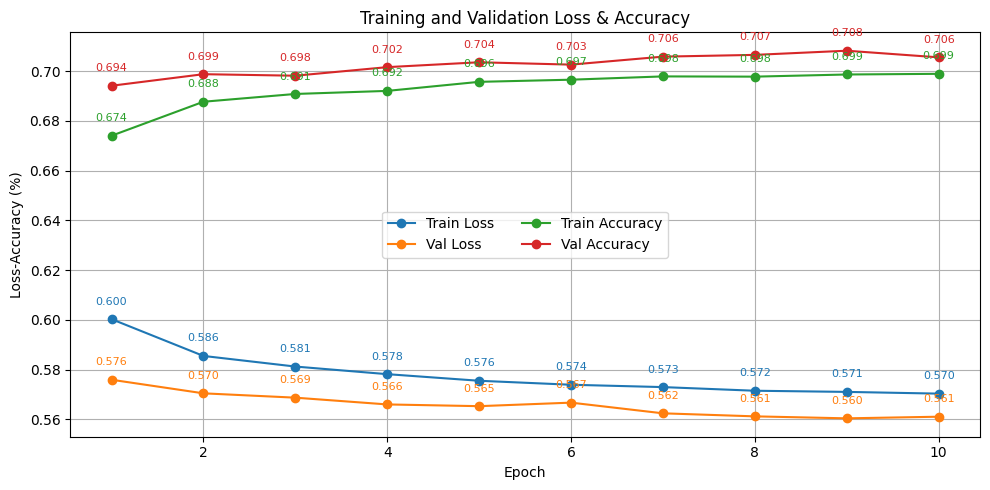

Experiment 1 - Finished


In [20]:
# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 10
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.3125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

print("Experiment 1 - Finished")

## Experiment 2 - Self-Trained Vectors

In [21]:
print("Experiment 2 - Started")

# Word2Vec
sentences = [word_tokenize(tweet) for tweet in df_train_preprocessed['Text']]
w2v_model = Word2Vec(sentences, vector_size=60, window=10, min_count=5, workers=4)

def self_trained_tweet_to_embedding(tweet, model):
    tokens = word_tokenize(tweet) # Tokenize the tweet text
    
    # Fetch the word embeddings for tokens present in the model vocabulary
    vecs = [model.wv[token] for token in tokens if token in model.wv]
    
    # If no tokens found, return a zero vector
    if not vecs:
        return np.zeros(model.vector_size)
    
    # Compute and return the average vector
    return np.mean(vecs, axis=0)

# Apply the tweet_to_embedding function
df_train_preprocessed['embedding'] = df_train_preprocessed['Text'].apply(lambda tweet: self_trained_tweet_to_embedding(tweet, w2v_model))
df_val_preprocessed['embedding']   = df_val_preprocessed['Text'].apply(lambda tweet: self_trained_tweet_to_embedding(tweet, w2v_model))
df_test_preprocessed['embedding']  = df_test_preprocessed['Text'].apply(lambda tweet: self_trained_tweet_to_embedding(tweet, w2v_model))

Experiment 2 - Started


In [22]:
# Convert data for PyTorch
train_embeddings = torch.tensor(np.stack(df_train_preprocessed['embedding'].values), dtype=torch.float)
train_labels = torch.tensor(df_train_preprocessed['Label'].values, dtype=torch.long)
val_embeddings = torch.tensor(np.stack(df_val_preprocessed['embedding'].values), dtype=torch.float)
val_labels = torch.tensor(df_val_preprocessed['Label'].values, dtype=torch.long)
test_embeddings = torch.tensor(np.stack(df_test_preprocessed['embedding'].values), dtype=torch.float)

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch   1: Train Loss = 0.53575, Train Acc = 0.73122 | Val Loss = 0.51202, Val Acc = 0.74651
Epoch   2: Train Loss = 0.52140, Train Acc = 0.74224 | Val Loss = 0.50479, Val Acc = 0.75205
Epoch   3: Train Loss = 0.51738, Train Acc = 0.74528 | Val Loss = 0.50342, Val Acc = 0.75142
Epoch   4: Train Loss = 0.51513, Train Acc = 0.74671 | Val Loss = 0.50190, Val Acc = 0.75217
Epoch   5: Train Loss = 0.51138, Train Acc = 0.74866 | Val Loss = 0.49939, Val Acc = 0.75528
Epoch   6: Train Loss = 0.51031, Train Acc = 0.74995 | Val Loss = 0.49877, Val Acc = 0.75698
Epoch   7: Train Loss = 0.50844, Train Acc = 0.74966 | Val Loss = 0.49757, Val Acc = 0.75587
Epoch   8: Train Loss = 0.50792, Train Acc = 0.75065 | Val Loss = 0.50040, Val Acc = 0.75535
Epoch   9: Train Loss = 0.50583, Train Acc = 0.75248 | Val Loss = 0.49642, Val Acc = 0.75686
Epoch  10: Train Loss = 0.50612, Train Acc = 0.75222 | Val Loss = 0.49790, Val Acc = 0.75479


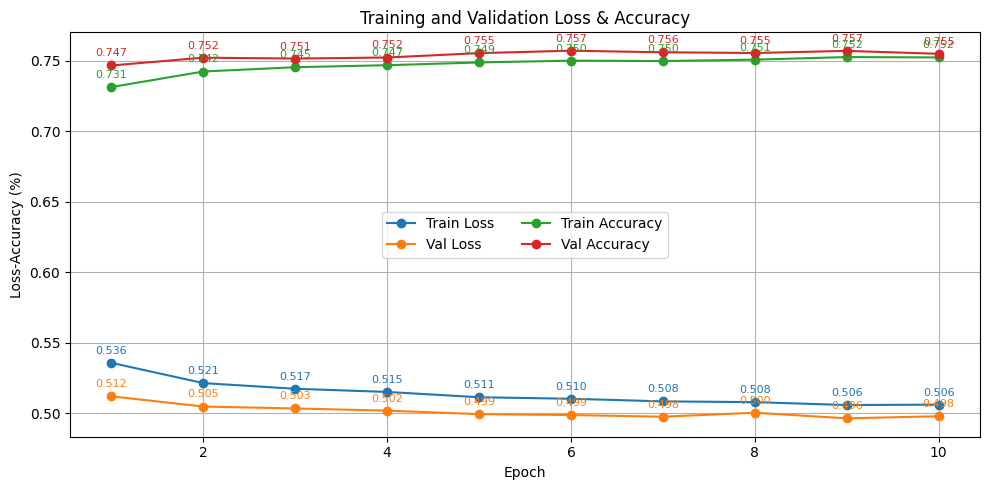

Experiment 2 - Finished


In [23]:
# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 10
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.3125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

print("Experiment 2 - Finished")

## Experiment 3 - Google News Vectors

In [24]:
# Note: If the google news vectors usage doesn't work in the below code, try the following commands:

# import gensim.downloader as api
# model = api.load("word2vec-google-news-300") # Download and load the model
# model.save("google_news_vectors.kv") # Save the model to a fil
# w2v_model = KeyedVectors.load("google_news_vectors.kv") # Load the previously saved model

In [25]:
print("Experiment 3 - Started")

# Word2Vec
w2v_path = "/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

df_train_preprocessed['embedding'] = df_train_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_val_preprocessed['embedding']   = df_val_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_test_preprocessed['embedding']  = df_test_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))

Experiment 3 - Started


In [26]:
# Convert data for PyTorch
train_embeddings = torch.tensor(np.stack(df_train_preprocessed['embedding'].values), dtype=torch.float)
train_labels = torch.tensor(df_train_preprocessed['Label'].values, dtype=torch.long)
val_embeddings = torch.tensor(np.stack(df_val_preprocessed['embedding'].values), dtype=torch.float)
val_labels = torch.tensor(df_val_preprocessed['Label'].values, dtype=torch.long)
test_embeddings = torch.tensor(np.stack(df_test_preprocessed['embedding'].values), dtype=torch.float)

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch   1: Train Loss = 0.51884, Train Acc = 0.74326 | Val Loss = 0.48955, Val Acc = 0.76274
Epoch   2: Train Loss = 0.49701, Train Acc = 0.75834 | Val Loss = 0.47983, Val Acc = 0.76913
Epoch   3: Train Loss = 0.48822, Train Acc = 0.76473 | Val Loss = 0.47404, Val Acc = 0.77276
Epoch   4: Train Loss = 0.48050, Train Acc = 0.76927 | Val Loss = 0.47311, Val Acc = 0.77300
Epoch   5: Train Loss = 0.47438, Train Acc = 0.77396 | Val Loss = 0.47327, Val Acc = 0.77321
Epoch   6: Train Loss = 0.46934, Train Acc = 0.77620 | Val Loss = 0.46861, Val Acc = 0.77444
Epoch   7: Train Loss = 0.46587, Train Acc = 0.77850 | Val Loss = 0.46732, Val Acc = 0.77580
Epoch   8: Train Loss = 0.46185, Train Acc = 0.78121 | Val Loss = 0.46654, Val Acc = 0.77670
Epoch   9: Train Loss = 0.45761, Train Acc = 0.78331 | Val Loss = 0.46666, Val Acc = 0.77635
Epoch  10: Train Loss = 0.45564, Train Acc = 0.78477 | Val Loss = 0.46638, Val Acc = 0.77715


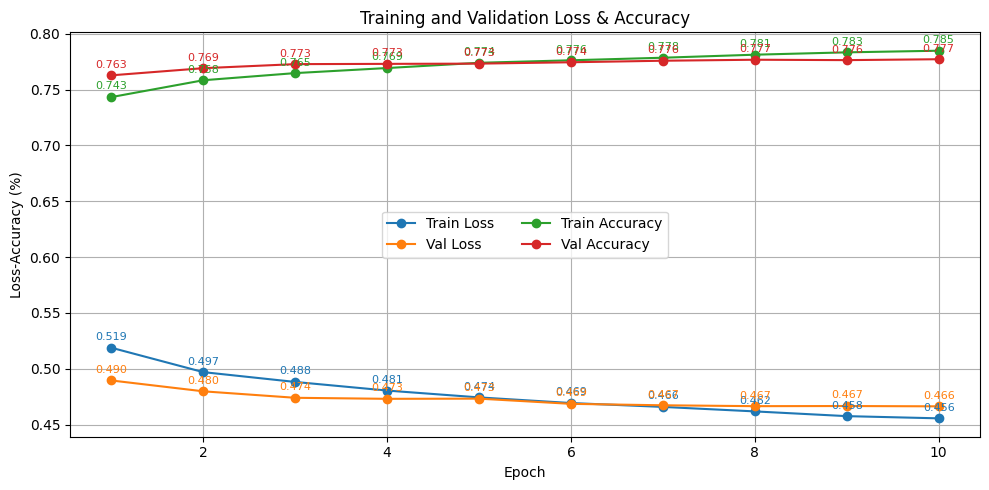

Experiment 3 - Finished


In [27]:
# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 10
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.3125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

print("Experiment 3 - Finished")

## Experiment 4 - Try glove.twitter.27b.200d.txt

In [28]:
print("Experiment 4 - Started")

# Word2Vec
glove_input_file = "/kaggle/input/glove-twitter/glove.twitter.27B.200d.txt"
w2v_output_file = 'glv_with_w2v_format'
glove2word2vec(glove_input_file, w2v_output_file)
w2v_model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

df_train_preprocessed['embedding'] = df_train_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_val_preprocessed['embedding']   = df_val_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_test_preprocessed['embedding']  = df_test_preprocessed['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))

Experiment 4 - Started


<ipython-input-28-ea734f5440d4>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, w2v_output_file)


In [29]:
# Convert data for PyTorch
train_embeddings = torch.tensor(np.stack(df_train_preprocessed['embedding'].values), dtype=torch.float)
train_labels = torch.tensor(df_train_preprocessed['Label'].values, dtype=torch.long)
val_embeddings = torch.tensor(np.stack(df_val_preprocessed['embedding'].values), dtype=torch.float)
val_labels = torch.tensor(df_val_preprocessed['Label'].values, dtype=torch.long)
test_embeddings = torch.tensor(np.stack(df_test_preprocessed['embedding'].values), dtype=torch.float)

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch   1: Train Loss = 0.49761, Train Acc = 0.75723 | Val Loss = 0.46829, Val Acc = 0.77481
Epoch   2: Train Loss = 0.47926, Train Acc = 0.76972 | Val Loss = 0.46402, Val Acc = 0.77845
Epoch   3: Train Loss = 0.47250, Train Acc = 0.77263 | Val Loss = 0.46162, Val Acc = 0.78014
Epoch   4: Train Loss = 0.46825, Train Acc = 0.77637 | Val Loss = 0.45710, Val Acc = 0.78246
Epoch   5: Train Loss = 0.46376, Train Acc = 0.77919 | Val Loss = 0.45745, Val Acc = 0.78144
Epoch   6: Train Loss = 0.46173, Train Acc = 0.78027 | Val Loss = 0.45641, Val Acc = 0.78114
Epoch   7: Train Loss = 0.45750, Train Acc = 0.78215 | Val Loss = 0.45310, Val Acc = 0.78323
Epoch   8: Train Loss = 0.45519, Train Acc = 0.78442 | Val Loss = 0.45684, Val Acc = 0.77937
Epoch   9: Train Loss = 0.45345, Train Acc = 0.78486 | Val Loss = 0.45671, Val Acc = 0.78208
Epoch  10: Train Loss = 0.45058, Train Acc = 0.78673 | Val Loss = 0.45310, Val Acc = 0.78489


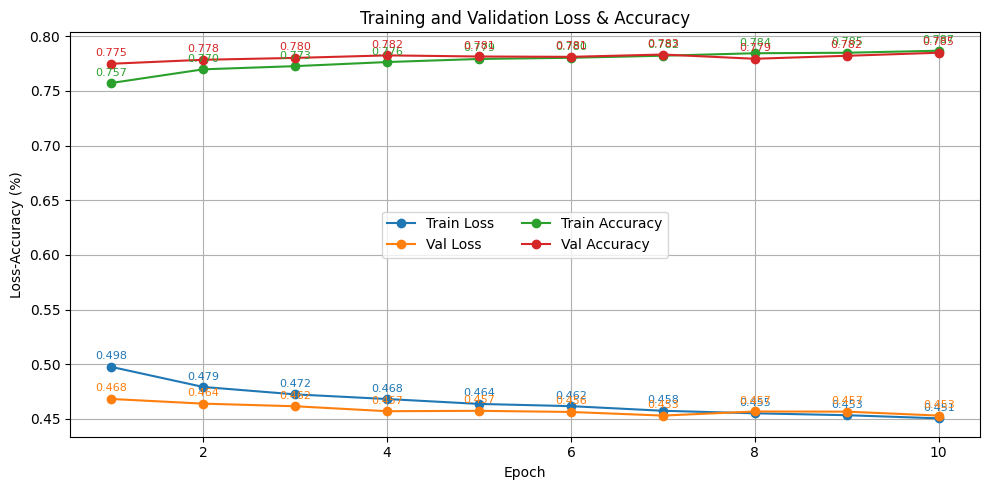

Accuracy: 0.784885
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78     21197
           1       0.78      0.80      0.79     21199

    accuracy                           0.78     42396
   macro avg       0.79      0.78      0.78     42396
weighted avg       0.79      0.78      0.78     42396



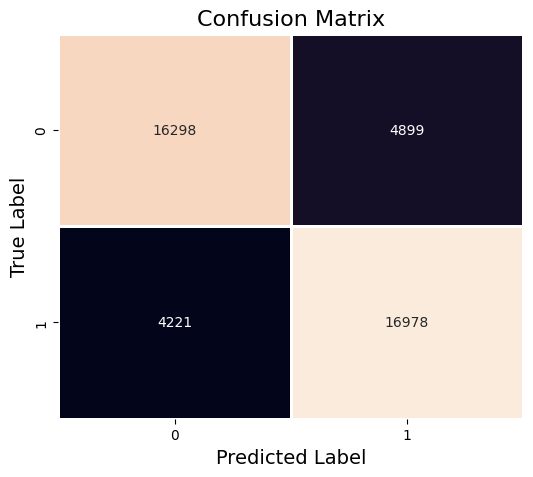

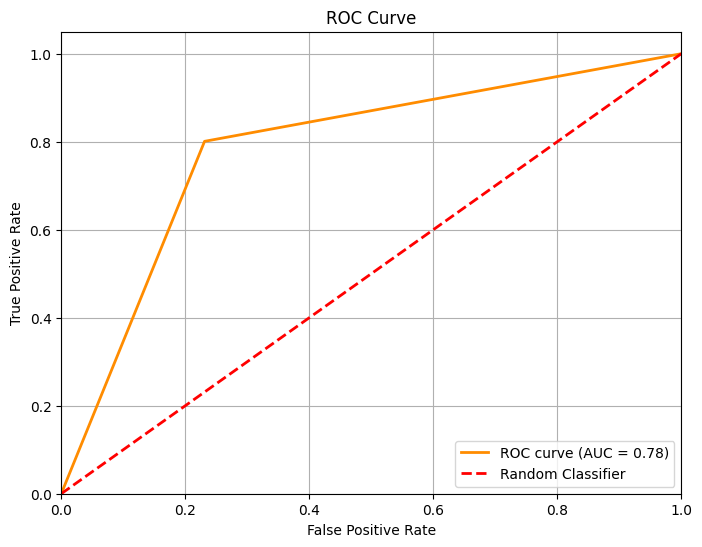

Experiment 4 - Finished


In [30]:
# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 10
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.3125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 4 - Finished")

## Experiment 5 - Try removing most frequent words

In [31]:
print("Experiment 5 - Started")

# Preprocess dfs
rmv_high_freq_words = True
df_train_preprocessed_exp5 = df_train.copy()
df_train_preprocessed_exp5["Text"] = df_train_preprocessed_exp5["Text"].apply(preprocess_text)
df_val_preprocessed_exp5 = df_val.copy()
df_val_preprocessed_exp5["Text"] = df_val_preprocessed_exp5["Text"].apply(preprocess_text)
df_test_preprocessed_exp5 = df_test.copy()
df_test_preprocessed_exp5["Text"] = df_test_preprocessed_exp5["Text"].apply(preprocess_text)
rmv_high_freq_words = False

Experiment 5 - Started


In [32]:
df_train_preprocessed_exp5['embedding'] = df_train_preprocessed_exp5['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_val_preprocessed_exp5['embedding']   = df_val_preprocessed_exp5['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))
df_test_preprocessed_exp5['embedding']  = df_test_preprocessed_exp5['Text'].apply(lambda tweet: tweet_to_embedding(tweet, w2v_model))

In [33]:
# Convert data for PyTorch
train_embeddings = torch.tensor(np.stack(df_train_preprocessed_exp5['embedding'].values), dtype=torch.float)
train_labels = torch.tensor(df_train_preprocessed_exp5['Label'].values, dtype=torch.long)
val_embeddings = torch.tensor(np.stack(df_val_preprocessed_exp5['embedding'].values), dtype=torch.float)
val_labels = torch.tensor(df_val_preprocessed_exp5['Label'].values, dtype=torch.long)
test_embeddings = torch.tensor(np.stack(df_test_preprocessed_exp5['embedding'].values), dtype=torch.float)

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch   1: Train Loss = 0.50127, Train Acc = 0.75526 | Val Loss = 0.47848, Val Acc = 0.76885
Epoch   2: Train Loss = 0.48265, Train Acc = 0.76788 | Val Loss = 0.46774, Val Acc = 0.77590
Epoch   3: Train Loss = 0.47613, Train Acc = 0.77181 | Val Loss = 0.46391, Val Acc = 0.77507
Epoch   4: Train Loss = 0.47145, Train Acc = 0.77420 | Val Loss = 0.46070, Val Acc = 0.77821
Epoch   5: Train Loss = 0.46671, Train Acc = 0.77772 | Val Loss = 0.45917, Val Acc = 0.78071
Epoch   6: Train Loss = 0.46438, Train Acc = 0.77948 | Val Loss = 0.45897, Val Acc = 0.78114
Epoch   7: Train Loss = 0.46069, Train Acc = 0.78204 | Val Loss = 0.45634, Val Acc = 0.78205
Epoch   8: Train Loss = 0.45843, Train Acc = 0.78237 | Val Loss = 0.45724, Val Acc = 0.78257
Epoch   9: Train Loss = 0.45510, Train Acc = 0.78418 | Val Loss = 0.45889, Val Acc = 0.78029
Epoch  10: Train Loss = 0.45317, Train Acc = 0.78429 | Val Loss = 0.45762, Val Acc = 0.78116


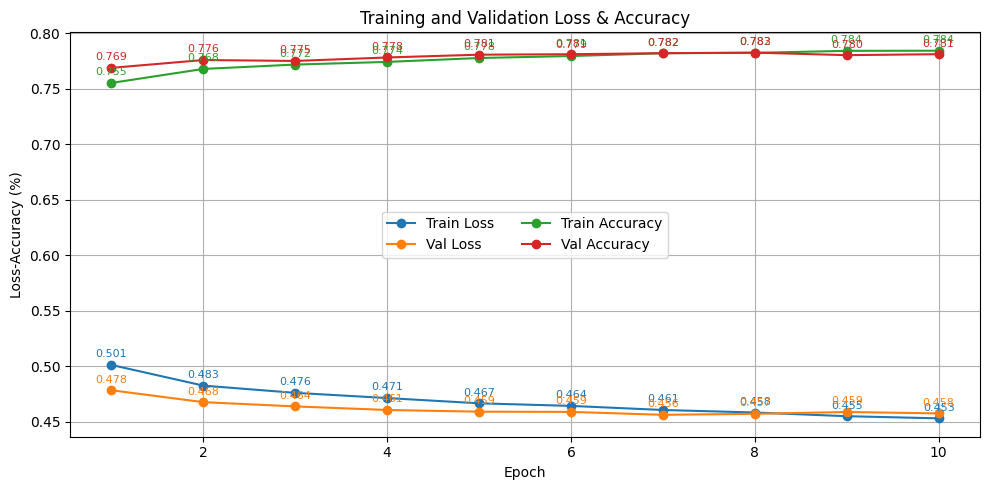

Accuracy: 0.781159
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79     21197
           1       0.80      0.75      0.77     21199

    accuracy                           0.78     42396
   macro avg       0.78      0.78      0.78     42396
weighted avg       0.78      0.78      0.78     42396



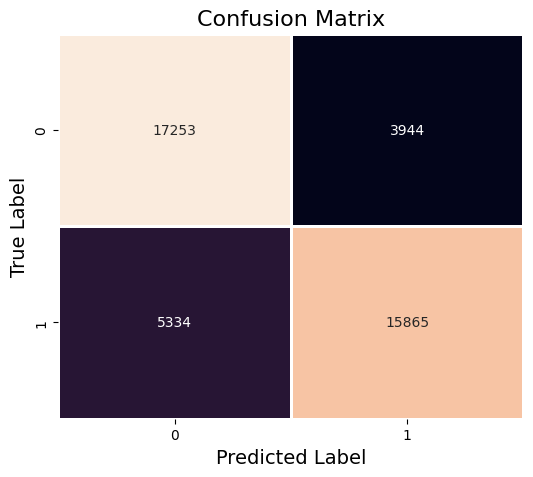

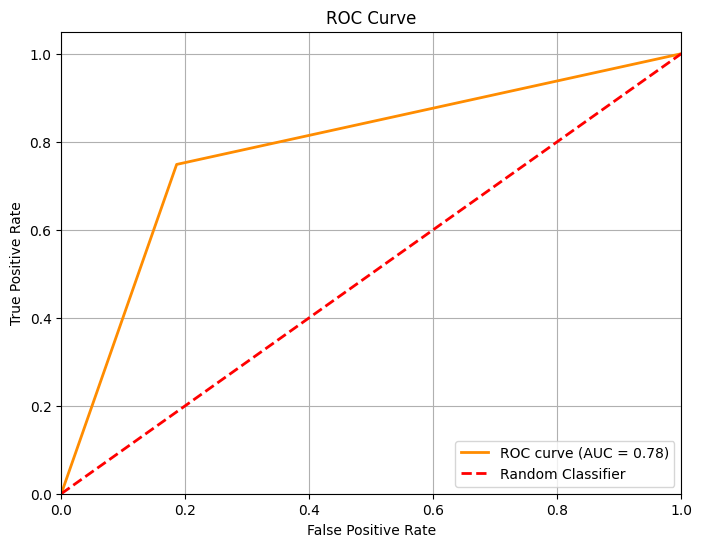

Experiment 5 - Finished


In [34]:
# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 10
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.3125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed_exp5)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 5 - Finished")

## Experiment 6 - Try not using dropout

In [35]:
print("Experiment 6 - Started")

# Convert data for PyTorch
train_embeddings = torch.tensor(np.stack(df_train_preprocessed['embedding'].values), dtype=torch.float)
train_labels = torch.tensor(df_train_preprocessed['Label'].values, dtype=torch.long)
val_embeddings = torch.tensor(np.stack(df_val_preprocessed['embedding'].values), dtype=torch.float)
val_labels = torch.tensor(df_val_preprocessed['Label'].values, dtype=torch.long)
test_embeddings = torch.tensor(np.stack(df_test_preprocessed['embedding'].values), dtype=torch.float)

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Experiment 6 - Started


Epoch   1: Train Loss = 0.48303, Train Acc = 0.76613 | Val Loss = 0.47148, Val Acc = 0.77021
Epoch   2: Train Loss = 0.46323, Train Acc = 0.77844 | Val Loss = 0.46438, Val Acc = 0.77500
Epoch   3: Train Loss = 0.45240, Train Acc = 0.78469 | Val Loss = 0.45727, Val Acc = 0.78069
Epoch   4: Train Loss = 0.44339, Train Acc = 0.78878 | Val Loss = 0.45443, Val Acc = 0.78168
Epoch   5: Train Loss = 0.43538, Train Acc = 0.79517 | Val Loss = 0.46728, Val Acc = 0.77517
Epoch   6: Train Loss = 0.42861, Train Acc = 0.79786 | Val Loss = 0.45768, Val Acc = 0.78128
Epoch   7: Train Loss = 0.42085, Train Acc = 0.80298 | Val Loss = 0.45833, Val Acc = 0.78375
Epoch   8: Train Loss = 0.41464, Train Acc = 0.80526 | Val Loss = 0.45928, Val Acc = 0.78149
Epoch   9: Train Loss = 0.40710, Train Acc = 0.81034 | Val Loss = 0.46398, Val Acc = 0.77795
Epoch  10: Train Loss = 0.40199, Train Acc = 0.81318 | Val Loss = 0.46798, Val Acc = 0.78066


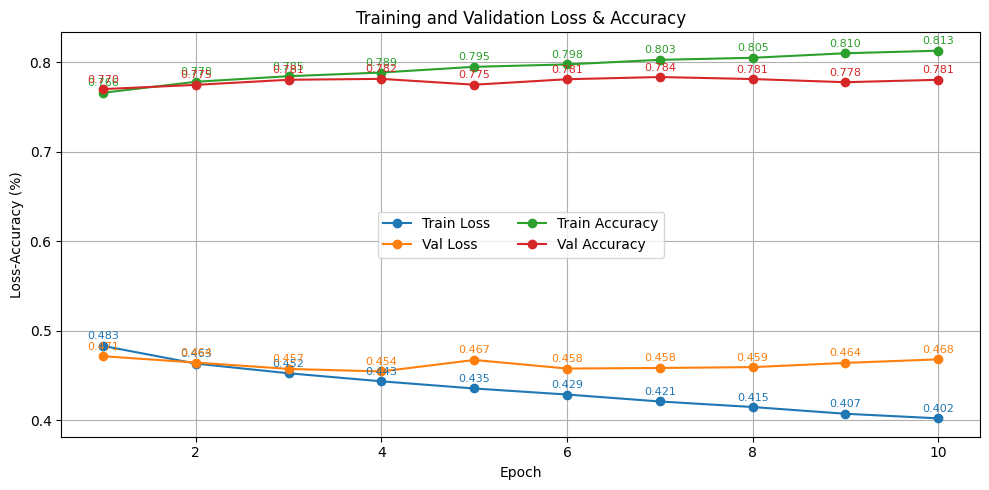

Accuracy: 0.780663
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79     21197
           1       0.80      0.75      0.77     21199

    accuracy                           0.78     42396
   macro avg       0.78      0.78      0.78     42396
weighted avg       0.78      0.78      0.78     42396



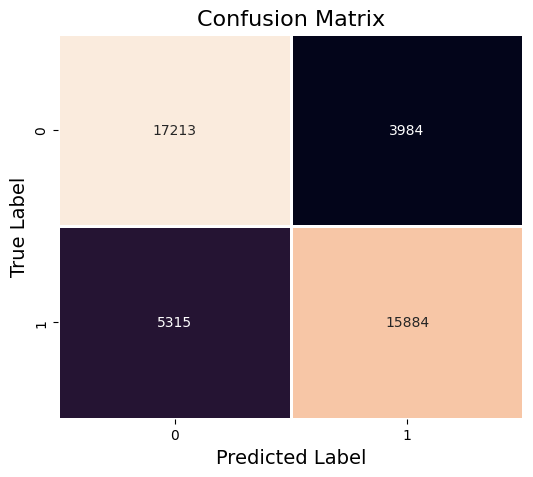

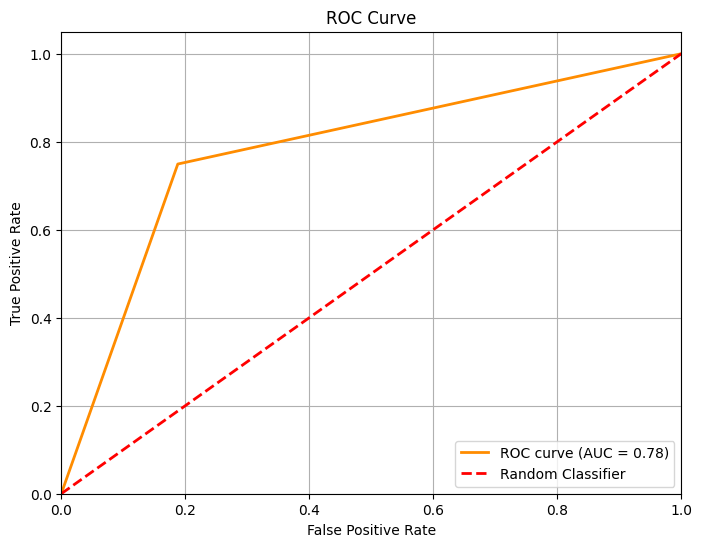

Experiment 6 - Finished


In [36]:
# To test not using dropout we just set the dropout_prob to zero.

# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 10
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 6 - Finished")

## Experiment 7 - Try using an 1 hidden layer architecture

Experiment 7 - Started
Epoch   1: Train Loss = 0.49086, Train Acc = 0.75935 | Val Loss = 0.47224, Val Acc = 0.77165
Epoch   2: Train Loss = 0.47144, Train Acc = 0.77316 | Val Loss = 0.46427, Val Acc = 0.77696
Epoch   3: Train Loss = 0.46221, Train Acc = 0.77894 | Val Loss = 0.46109, Val Acc = 0.77861
Epoch   4: Train Loss = 0.45523, Train Acc = 0.78277 | Val Loss = 0.46015, Val Acc = 0.78029
Epoch   5: Train Loss = 0.44914, Train Acc = 0.78745 | Val Loss = 0.46549, Val Acc = 0.77769
Epoch   6: Train Loss = 0.44354, Train Acc = 0.79017 | Val Loss = 0.46051, Val Acc = 0.78090
Epoch   7: Train Loss = 0.43873, Train Acc = 0.79247 | Val Loss = 0.45990, Val Acc = 0.78210
Epoch   8: Train Loss = 0.43417, Train Acc = 0.79500 | Val Loss = 0.46330, Val Acc = 0.78022
Epoch   9: Train Loss = 0.42982, Train Acc = 0.79792 | Val Loss = 0.46308, Val Acc = 0.78217
Epoch  10: Train Loss = 0.42560, Train Acc = 0.80029 | Val Loss = 0.46576, Val Acc = 0.77899


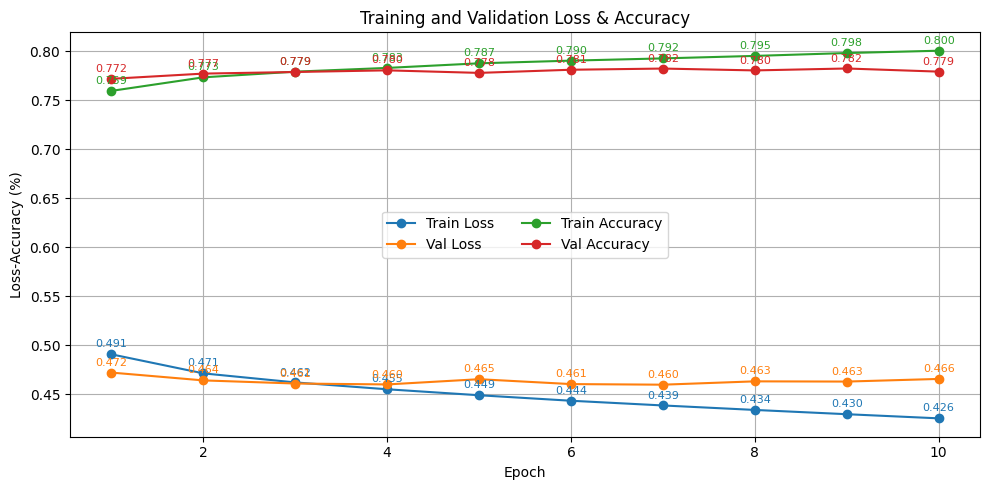

Accuracy: 0.778989
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.78     21197
           1       0.77      0.80      0.78     21199

    accuracy                           0.78     42396
   macro avg       0.78      0.78      0.78     42396
weighted avg       0.78      0.78      0.78     42396



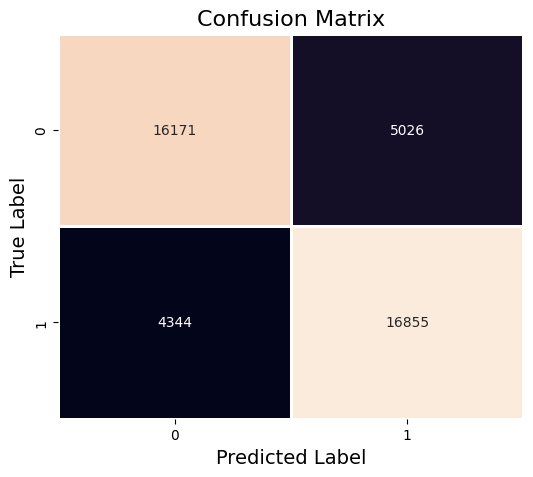

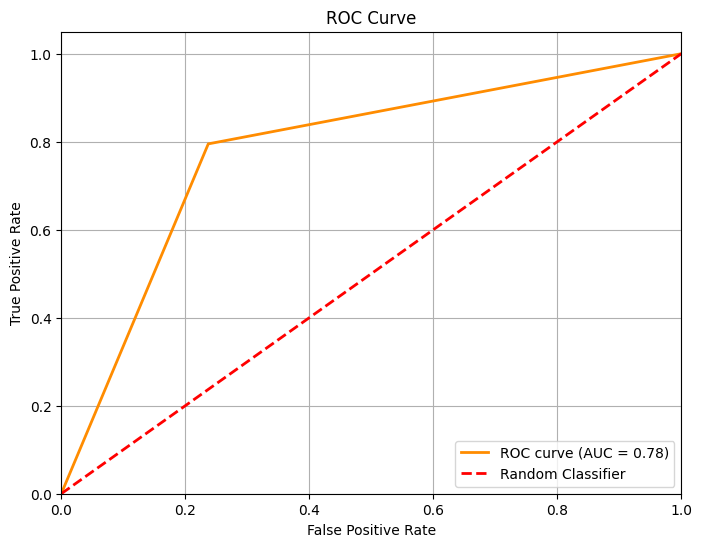

Experiment 7 - Finished


In [37]:
print("Experiment 7 - Started")

# Evaluation
D_in = train_embeddings.shape[1]
H1=128
D_out = 2
num_epochs = 10
model = Relu1Layer(D_in, H1, D_out, dropout_prob=0.3125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 7 - Finished")

## Experiment 8 - Try using a 3 hidden layers architecture

Experiment 8 - Started
Epoch   1: Train Loss = 0.51468, Train Acc = 0.74843 | Val Loss = 0.47223, Val Acc = 0.77201
Epoch   2: Train Loss = 0.49158, Train Acc = 0.76559 | Val Loss = 0.46567, Val Acc = 0.77566
Epoch   3: Train Loss = 0.48481, Train Acc = 0.77007 | Val Loss = 0.46560, Val Acc = 0.77760
Epoch   4: Train Loss = 0.48029, Train Acc = 0.77285 | Val Loss = 0.46386, Val Acc = 0.77708
Epoch   5: Train Loss = 0.47728, Train Acc = 0.77449 | Val Loss = 0.45818, Val Acc = 0.78184
Epoch   6: Train Loss = 0.47393, Train Acc = 0.77614 | Val Loss = 0.45799, Val Acc = 0.78149
Epoch   7: Train Loss = 0.47150, Train Acc = 0.77753 | Val Loss = 0.45728, Val Acc = 0.78177
Epoch   8: Train Loss = 0.47040, Train Acc = 0.77874 | Val Loss = 0.45264, Val Acc = 0.78472
Epoch   9: Train Loss = 0.46710, Train Acc = 0.78051 | Val Loss = 0.45504, Val Acc = 0.78260
Epoch  10: Train Loss = 0.46552, Train Acc = 0.78140 | Val Loss = 0.45370, Val Acc = 0.78354
Epoch  11: Train Loss = 0.46490, Train Acc = 0.

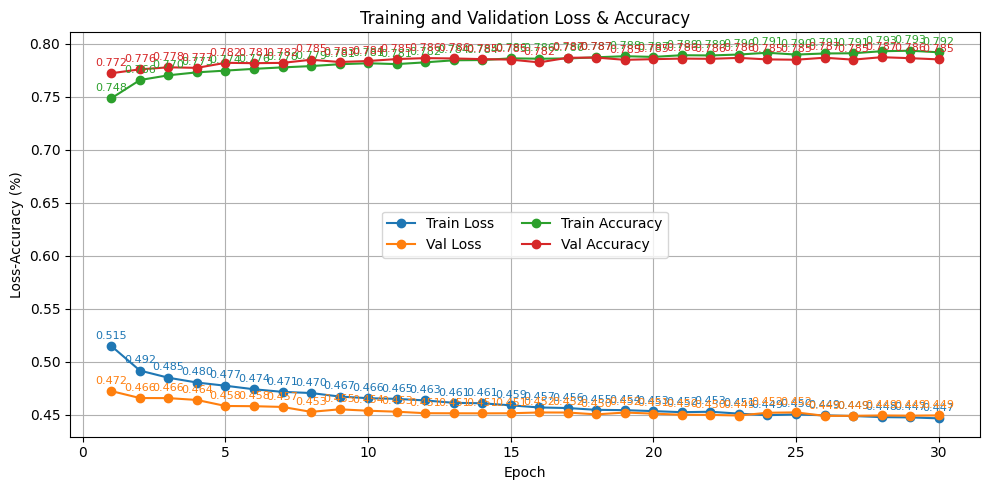

Accuracy: 0.785074
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     21197
           1       0.79      0.77      0.78     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



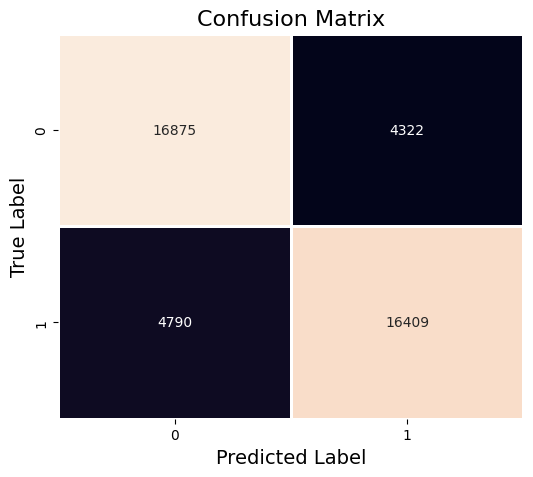

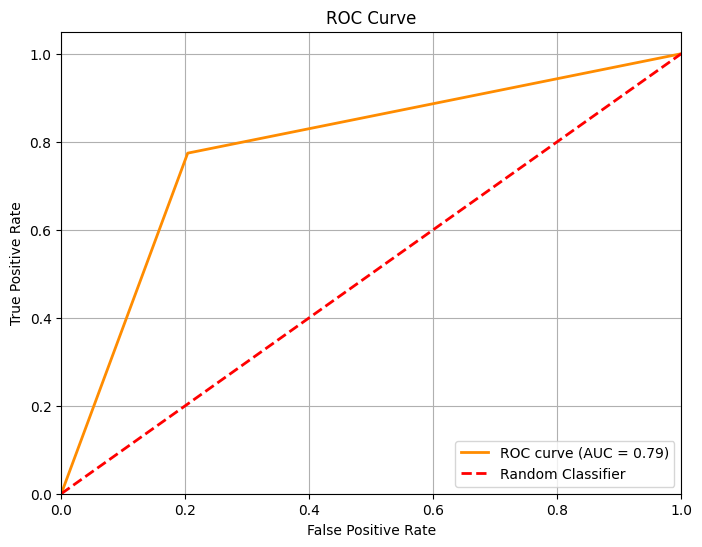

Experiment 8 - Finished


In [38]:
print("Experiment 8 - Started")

# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
H3=32
D_out = 2
model = Relu3Layers(D_in, H1, H2, H3, D_out, dropout_prob=0.4125125247127012)
num_epochs = 30
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 8 - Finished")

## Experiment 9 - 2 hidden layers with more epochs and dropout_prob 

Experiment 9 - Started
Epoch   1: Train Loss = 0.50432, Train Acc = 0.75308 | Val Loss = 0.47750, Val Acc = 0.76727
Epoch   2: Train Loss = 0.48497, Train Acc = 0.76688 | Val Loss = 0.46594, Val Acc = 0.77687
Epoch   3: Train Loss = 0.47926, Train Acc = 0.77181 | Val Loss = 0.46078, Val Acc = 0.77764
Epoch   4: Train Loss = 0.47437, Train Acc = 0.77365 | Val Loss = 0.46223, Val Acc = 0.78092
Epoch   5: Train Loss = 0.47156, Train Acc = 0.77441 | Val Loss = 0.46019, Val Acc = 0.77906
Epoch   6: Train Loss = 0.46871, Train Acc = 0.77591 | Val Loss = 0.45734, Val Acc = 0.78154
Epoch   7: Train Loss = 0.46668, Train Acc = 0.77796 | Val Loss = 0.45521, Val Acc = 0.78361
Epoch   8: Train Loss = 0.46384, Train Acc = 0.77963 | Val Loss = 0.45544, Val Acc = 0.78231
Epoch   9: Train Loss = 0.46216, Train Acc = 0.78203 | Val Loss = 0.45631, Val Acc = 0.78272
Epoch  10: Train Loss = 0.45982, Train Acc = 0.78162 | Val Loss = 0.45223, Val Acc = 0.78628
Epoch  11: Train Loss = 0.45806, Train Acc = 0.

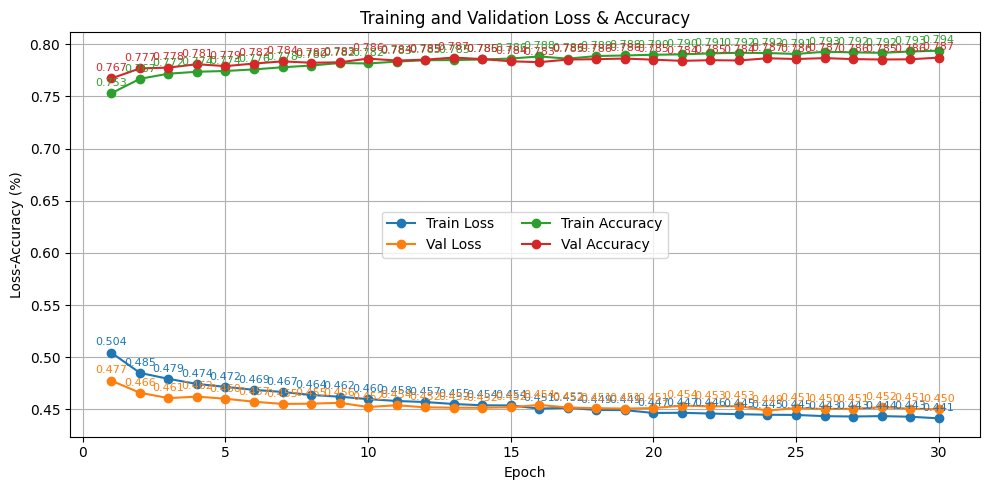

Accuracy: 0.787197
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79     21197
           1       0.79      0.79      0.79     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



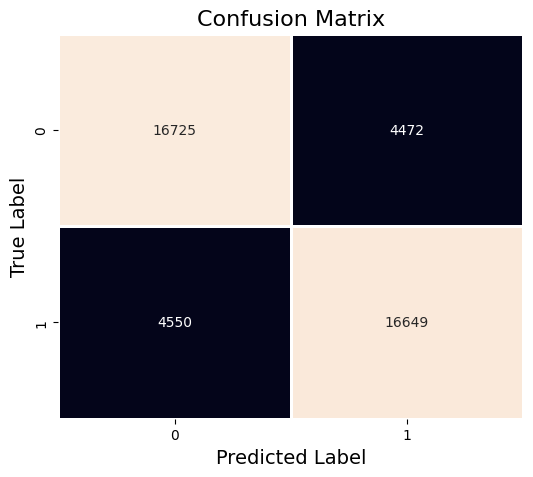

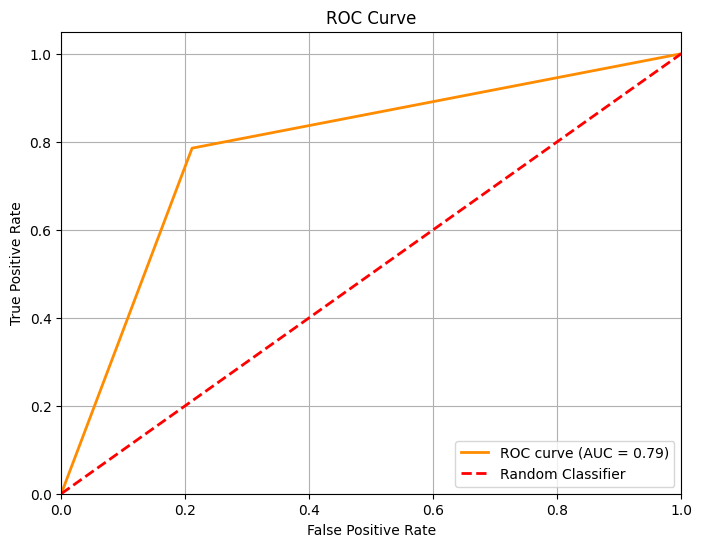

Experiment 9 - Finished


In [39]:
print("Experiment 9 - Started")

# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 30
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.4125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 9 - Finished")

## Experiment 10 - Try using GELU with 2 layers

Experiment 10 - Started
Epoch   1: Train Loss = 0.49759, Train Acc = 0.75640 | Val Loss = 0.47243, Val Acc = 0.77184
Epoch   2: Train Loss = 0.47991, Train Acc = 0.76861 | Val Loss = 0.46175, Val Acc = 0.77628
Epoch   3: Train Loss = 0.47438, Train Acc = 0.77228 | Val Loss = 0.45790, Val Acc = 0.78031
Epoch   4: Train Loss = 0.46889, Train Acc = 0.77519 | Val Loss = 0.45809, Val Acc = 0.78118
Epoch   5: Train Loss = 0.46527, Train Acc = 0.77753 | Val Loss = 0.45662, Val Acc = 0.78059
Epoch   6: Train Loss = 0.46299, Train Acc = 0.77770 | Val Loss = 0.45299, Val Acc = 0.78340
Epoch   7: Train Loss = 0.45881, Train Acc = 0.78144 | Val Loss = 0.45499, Val Acc = 0.78102
Epoch   8: Train Loss = 0.45647, Train Acc = 0.78279 | Val Loss = 0.45182, Val Acc = 0.78425
Epoch   9: Train Loss = 0.45507, Train Acc = 0.78325 | Val Loss = 0.44924, Val Acc = 0.78543
Epoch  10: Train Loss = 0.45421, Train Acc = 0.78450 | Val Loss = 0.45078, Val Acc = 0.78335
Epoch  11: Train Loss = 0.45278, Train Acc = 0

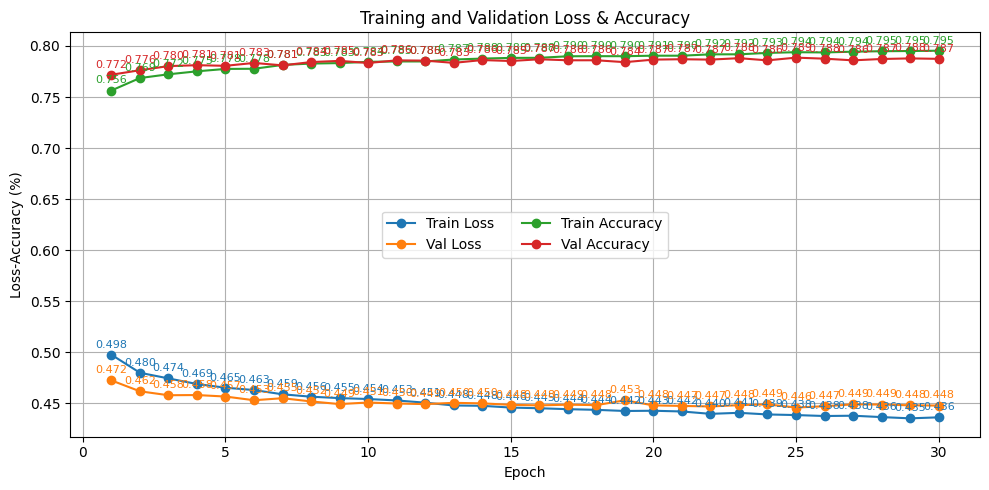

Accuracy: 0.787409
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     21197
           1       0.79      0.77      0.78     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



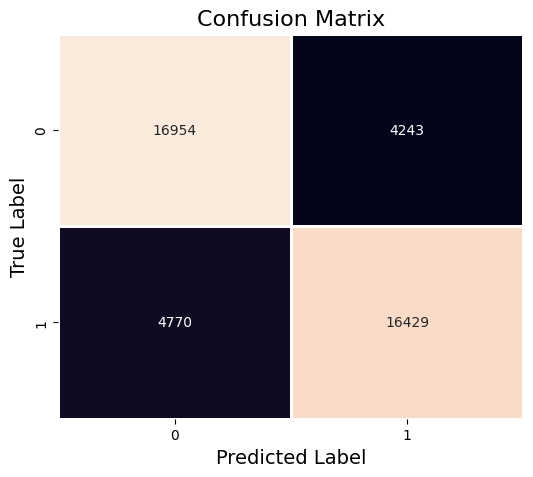

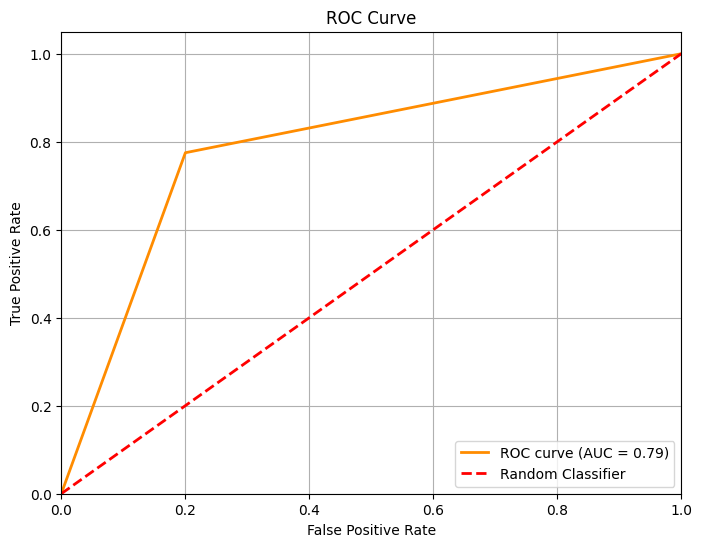

Experiment 10 - Finished


In [40]:
print("Experiment 10 - Started")

# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 30
model = Gelu2Layers(D_in, H1, H2, D_out, dropout_prob=0.4125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 10 - Finished")

## Experiment 11 - Reduce Batch Size

In [41]:
print("Experiment 11 - Started")

# Get dataloaders
batch_size = 64
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Experiment 11 - Started


Epoch   1: Train Loss = 0.50704, Train Acc = 0.75087 | Val Loss = 0.47552, Val Acc = 0.76958
Epoch   2: Train Loss = 0.48926, Train Acc = 0.76398 | Val Loss = 0.46596, Val Acc = 0.77564
Epoch   3: Train Loss = 0.48354, Train Acc = 0.76681 | Val Loss = 0.46292, Val Acc = 0.77802
Epoch   4: Train Loss = 0.47990, Train Acc = 0.77016 | Val Loss = 0.46418, Val Acc = 0.77833
Epoch   5: Train Loss = 0.47698, Train Acc = 0.77262 | Val Loss = 0.45856, Val Acc = 0.78243
Epoch   6: Train Loss = 0.47407, Train Acc = 0.77367 | Val Loss = 0.45950, Val Acc = 0.78083
Epoch   7: Train Loss = 0.47197, Train Acc = 0.77524 | Val Loss = 0.45750, Val Acc = 0.78102
Epoch   8: Train Loss = 0.46983, Train Acc = 0.77670 | Val Loss = 0.45496, Val Acc = 0.78364
Epoch   9: Train Loss = 0.46823, Train Acc = 0.77724 | Val Loss = 0.45561, Val Acc = 0.78116
Epoch  10: Train Loss = 0.46742, Train Acc = 0.77808 | Val Loss = 0.45329, Val Acc = 0.78366
Epoch  11: Train Loss = 0.46564, Train Acc = 0.77828 | Val Loss = 0.45

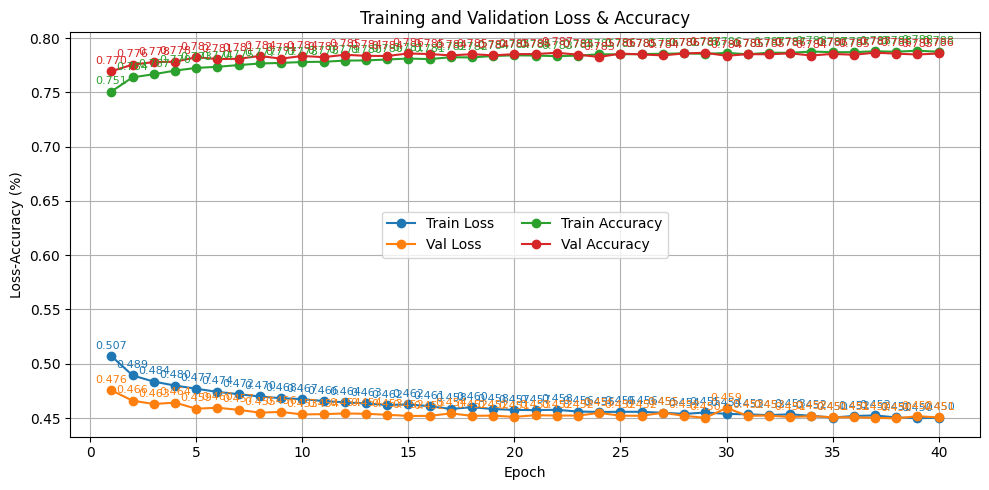

Accuracy: 0.785947
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78     21197
           1       0.78      0.80      0.79     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



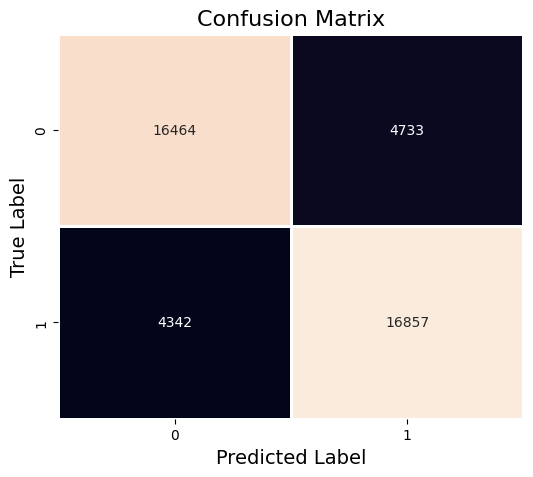

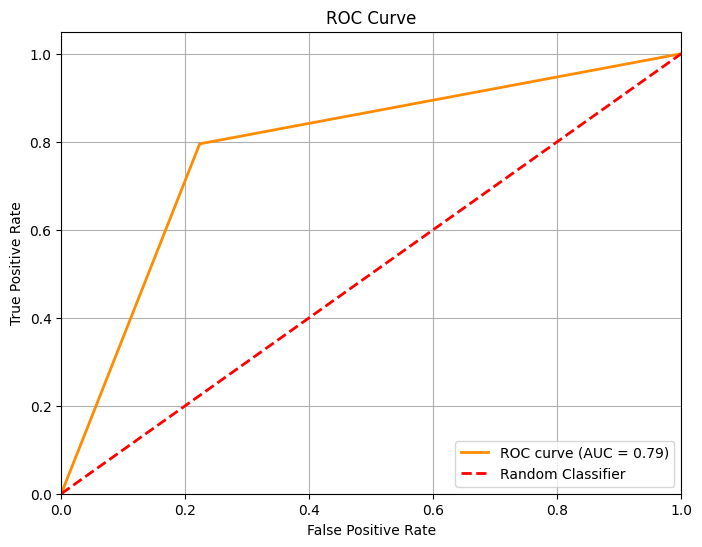

Experiment 11 - Finished


In [42]:
# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 40
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.4125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 11 - Finished")

## Experiment 12 - Increase Batch Size

In [43]:
print("Experiment 12 - Started")

# Get dataloaders
batch_size = 256
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Experiment 12 - Started


Epoch   1: Train Loss = 0.50340, Train Acc = 0.75353 | Val Loss = 0.47616, Val Acc = 0.76837
Epoch   2: Train Loss = 0.48198, Train Acc = 0.76702 | Val Loss = 0.46446, Val Acc = 0.77771
Epoch   3: Train Loss = 0.47576, Train Acc = 0.77234 | Val Loss = 0.46047, Val Acc = 0.77826
Epoch   4: Train Loss = 0.47136, Train Acc = 0.77462 | Val Loss = 0.46202, Val Acc = 0.77668
Epoch   5: Train Loss = 0.46706, Train Acc = 0.77782 | Val Loss = 0.45705, Val Acc = 0.78248
Epoch   6: Train Loss = 0.46564, Train Acc = 0.77887 | Val Loss = 0.45674, Val Acc = 0.78286
Epoch   7: Train Loss = 0.46292, Train Acc = 0.78045 | Val Loss = 0.46021, Val Acc = 0.77779
Epoch   8: Train Loss = 0.46087, Train Acc = 0.78263 | Val Loss = 0.45435, Val Acc = 0.78378
Epoch   9: Train Loss = 0.45908, Train Acc = 0.78274 | Val Loss = 0.45426, Val Acc = 0.78229
Epoch  10: Train Loss = 0.45693, Train Acc = 0.78527 | Val Loss = 0.45314, Val Acc = 0.78380
Epoch  11: Train Loss = 0.45467, Train Acc = 0.78511 | Val Loss = 0.45

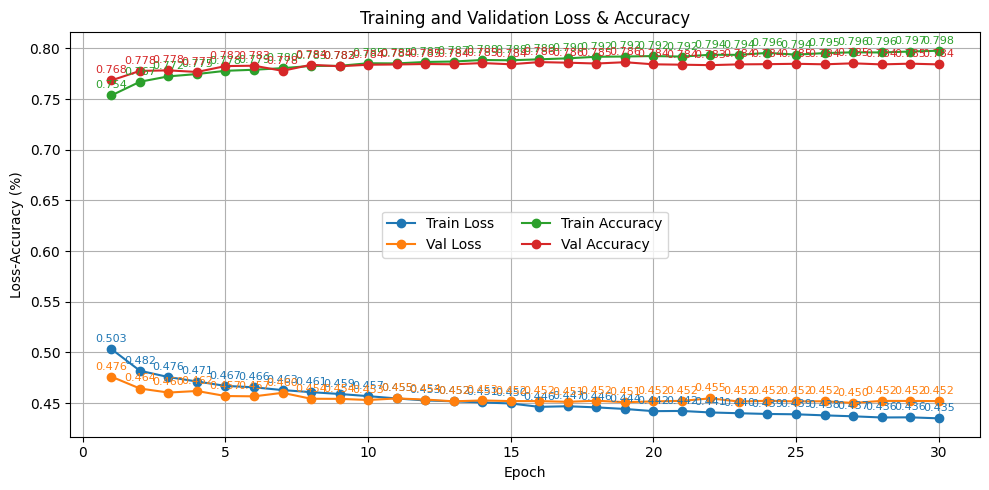

Accuracy: 0.784154
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     21197
           1       0.79      0.77      0.78     21199

    accuracy                           0.78     42396
   macro avg       0.78      0.78      0.78     42396
weighted avg       0.78      0.78      0.78     42396



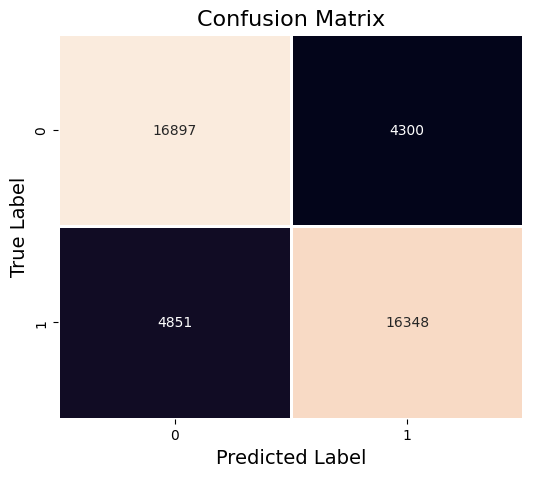

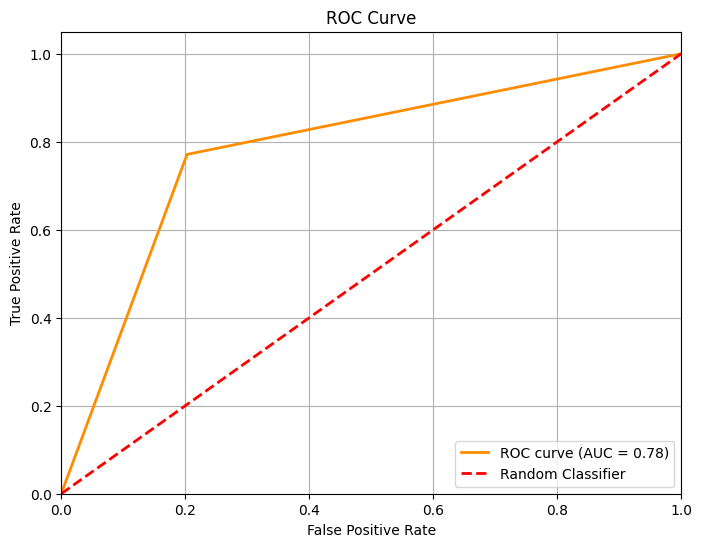

Experiment 12 - Finished


In [44]:
# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 30
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.4125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 12 - Finished")

## Experiment 13 - Optimization

### Suggest Hyperparameters

In [45]:
def suggest_hyperparameters(trial): #function to include the suggested hyperparameters
    # Suggest optimizer type, now including "SGD"
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "AdamW"])
    
    # Suggest learning rate on a log scale
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    
    # Suggest weight decay
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Suggest dropout_prob
    dropout_prob = trial.suggest_float("dropout_prob", 0.25, 0.5)
    
    return optimizer_name, learning_rate, weight_decay, dropout_prob

### Objective Function

In [46]:
def objective(trial):
    # Suggest hyperparameters
    optimizer_name, learning_rate, weight_decay, dropout_prob = suggest_hyperparameters(trial)
    
    # Init model
    D_in = train_embeddings.shape[1]
    H1=128
    H2=64
    # H3=32
    D_out = 2
    model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=dropout_prob)
    # model = Relu3Layers(D_in, H1, H2, H3, D_out, dropout_prob=dropout_prob)

    # Choose the optimizer
    num_epochs=20
    loss_func = nn.CrossEntropyLoss() # You can also try BCELoss and BCEWithLogitsLoss
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Train model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
    return val_losses[-1]

### Optimization Process

In [47]:
## The following lines are starting the optimization but will be kept commented to avoid delaying the submit.

# print("Optimization Process - Started")

# optuna_sample = optuna.create_study(direction = 'minimize', study_name = 'lr-minim-sample')
# optuna_sample.optimize(objective, n_trials = 50) #the first parameter is the function that we want to optimise
# print('numbers of the finished trials:' , len(optuna_sample.trials))
# print('the best params:' , optuna_sample.best_trial.params)
# print('the best value:' , optuna_sample.best_value)

# print("Optimization Process - Finished")

Experiment 13 - Started
Epoch   1: Train Loss = 0.50409, Train Acc = 0.75203 | Val Loss = 0.47618, Val Acc = 0.77154
Epoch   2: Train Loss = 0.48234, Train Acc = 0.76758 | Val Loss = 0.46221, Val Acc = 0.77790
Epoch   3: Train Loss = 0.47525, Train Acc = 0.77123 | Val Loss = 0.45858, Val Acc = 0.77972
Epoch   4: Train Loss = 0.47163, Train Acc = 0.77380 | Val Loss = 0.45998, Val Acc = 0.78220
Epoch   5: Train Loss = 0.46700, Train Acc = 0.77753 | Val Loss = 0.45869, Val Acc = 0.78168
Epoch   6: Train Loss = 0.46455, Train Acc = 0.77879 | Val Loss = 0.45521, Val Acc = 0.78279
Epoch   7: Train Loss = 0.46051, Train Acc = 0.78138 | Val Loss = 0.45406, Val Acc = 0.78170
Epoch   8: Train Loss = 0.45775, Train Acc = 0.78253 | Val Loss = 0.45420, Val Acc = 0.78335
Epoch   9: Train Loss = 0.45710, Train Acc = 0.78398 | Val Loss = 0.45488, Val Acc = 0.78224
Epoch  10: Train Loss = 0.45467, Train Acc = 0.78494 | Val Loss = 0.45368, Val Acc = 0.78484
Epoch  11: Train Loss = 0.45289, Train Acc = 0

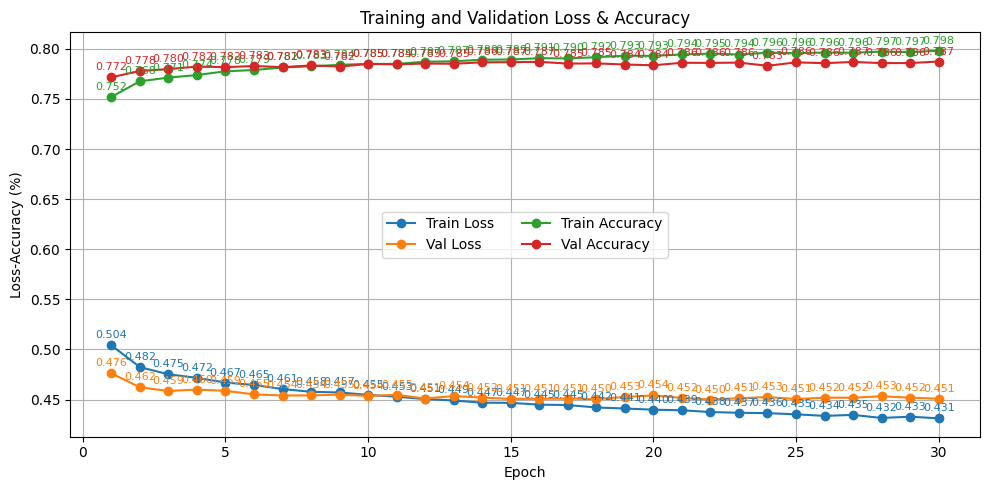

Accuracy: 0.787291
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79     21197
           1       0.80      0.76      0.78     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



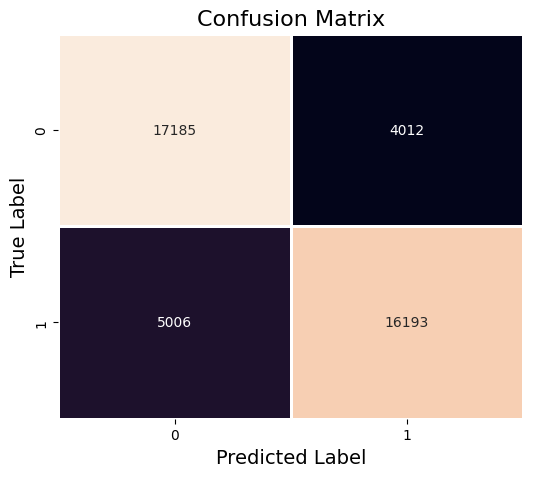

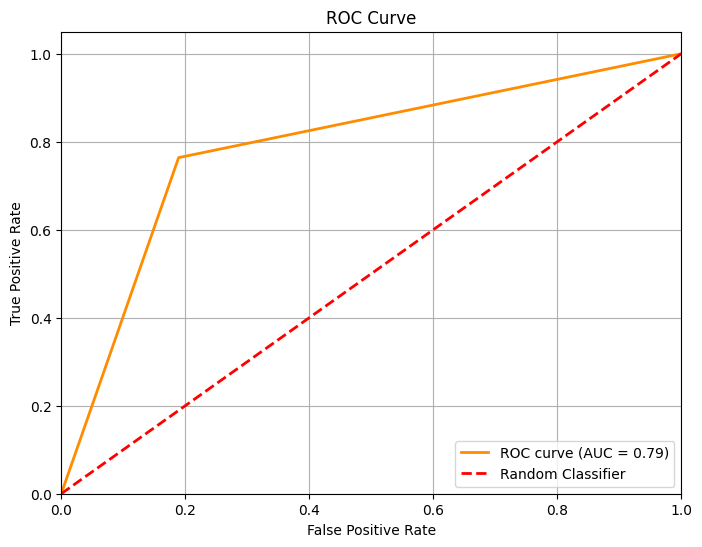

Experiment 13 - Finished


In [48]:
print("Experiment 13 - Started")

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.3553718703420643)
num_epochs = 30
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0010291927407311168, weight_decay=8.018811458914011e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Experiment 13 - Finished")

# Evaluation of best model

## Train and Evaluate Best Model

Train and Evaluate Best Model - Started
Epoch   1: Train Loss = 0.50246, Train Acc = 0.75530 | Val Loss = 0.47110, Val Acc = 0.77389
Epoch   2: Train Loss = 0.48478, Train Acc = 0.76679 | Val Loss = 0.47043, Val Acc = 0.77550
Epoch   3: Train Loss = 0.47799, Train Acc = 0.77076 | Val Loss = 0.46070, Val Acc = 0.77918
Epoch   4: Train Loss = 0.47478, Train Acc = 0.77353 | Val Loss = 0.46316, Val Acc = 0.77892
Epoch   5: Train Loss = 0.47106, Train Acc = 0.77593 | Val Loss = 0.45925, Val Acc = 0.77972
Epoch   6: Train Loss = 0.46775, Train Acc = 0.77783 | Val Loss = 0.45662, Val Acc = 0.78170
Epoch   7: Train Loss = 0.46486, Train Acc = 0.77885 | Val Loss = 0.45361, Val Acc = 0.78125
Epoch   8: Train Loss = 0.46362, Train Acc = 0.78012 | Val Loss = 0.45358, Val Acc = 0.78569
Epoch   9: Train Loss = 0.46212, Train Acc = 0.78134 | Val Loss = 0.45615, Val Acc = 0.78375
Epoch  10: Train Loss = 0.46011, Train Acc = 0.78184 | Val Loss = 0.45587, Val Acc = 0.78194
Epoch  11: Train Loss = 0.4588

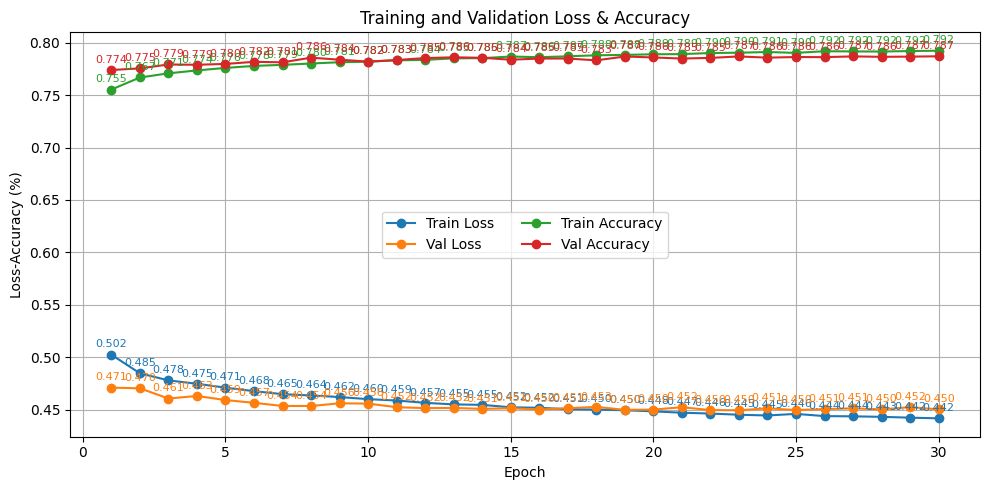

Accuracy: 0.786985
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     21197
           1       0.80      0.77      0.78     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



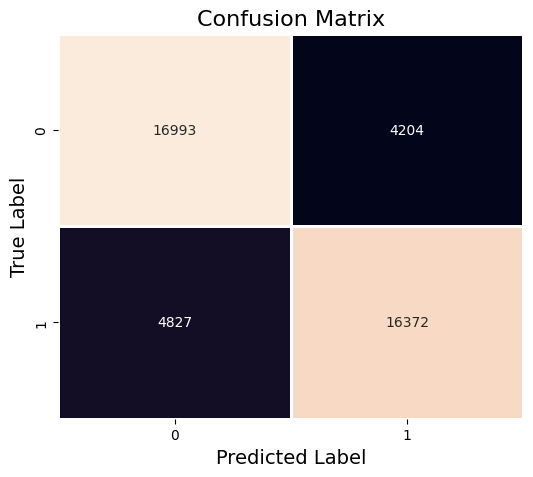

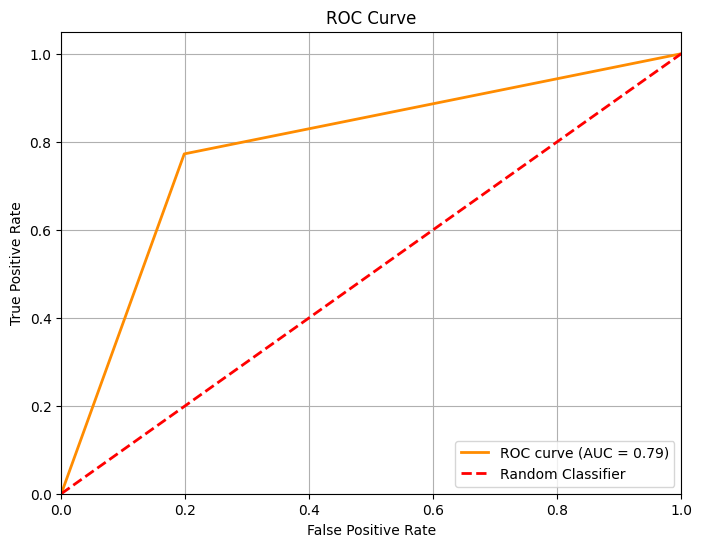

Train and Evaluate Best Model - Finished


In [49]:
print("Train and Evaluate Best Model - Started")

# Get dataloaders
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Evaluation
D_in = train_embeddings.shape[1]
H1=128
H2=64
D_out = 2
num_epochs = 30
model = Relu2Layers(D_in, H1, H2, D_out, dropout_prob=0.4125125247127012)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0019524310388177159, weight_decay=5.263544573640884e-06)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=num_epochs)
print_loss_and_accuracy_plot(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

# Accuracy - Classification Report - Plots
y_val, y_pred = getYValAndYPred(model, val_embeddings, df_val_preprocessed)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print_confusion_matrix(y_val, y_pred)
print_roc(y_val, y_pred)

print("Train and Evaluate Best Model - Finished")

# Submission

In [50]:
# Generate evaluation predictions
model.eval()
with torch.no_grad():
    outputs = model(test_embeddings)
    _, predictions = torch.max(outputs, 1)
predictions = predictions.cpu().numpy().tolist()

In [51]:
submission = pd.DataFrame({
    'ID': df_test_preprocessed['ID'],
    'Label': predictions
})

submission.to_csv("/kaggle/working/submission.csv", index=False)